In [1]:
import glob
import os
import librosa
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns
%matplotlib inline

import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.utils import to_categorical 


import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.utils import class_weight
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

from livelossplot.inputs.tf_keras import PlotLossesCallback




from scipy.io import wavfile as wav
import struct
import IPython.display as ipd

plt.style.use('ggplot')


In [2]:
# constants

DATA_PATH = "../../../datasets/FSD50K/"
#DATA_PATH = "../../../data_sets/FSD50K/"
DEV_CSV_FILE  = "train_df.csv"
EVAL_CSV_FILE = "test_df.csv"
DEV_AUDIO_DATASET_PATH = "dev_audio/"


In [3]:
#Load datasets
dev_csv_dataset = pd.read_csv(DEV_CSV_FILE, sep= ';')
eval_csv_dataset = pd.read_csv(EVAL_CSV_FILE, sep= ';')
dev_csv_dataset.head()
eval_csv_dataset.head()

,Unnamed: 0,Unnamed: 0.1,fname,labels,mids
0,0,0,37199,Electric_guitar,/m/02sgy
1,1,1,175151,Electric_guitar,/m/02sgy
2,2,2,253463,Electric_guitar,/m/02sgy
3,3,3,329838,Electric_guitar,/m/02sgy
4,4,4,1277,Electric_guitar,/m/02sgy


In [4]:
labels_train =[j for i in dev_csv_dataset['labels'].values.tolist() for j in str(i).split(',')]

In [5]:
labels_eval =[j for i in eval_csv_dataset['labels'].values.tolist() for j in str(i).split(',')]

In [6]:
K=100
df_sup_count = pd.Series(labels_train).value_counts().to_frame('count').reset_index(level=0, inplace=False).sort_values('count', ascending=False).head(K)

In [7]:
df_sup_count_eval = pd.Series(labels_eval).value_counts().to_frame('count').reset_index(level=0, inplace=False).sort_values('count', ascending=False).head(K)

In [8]:
df_inf_count = pd.Series(labels_train).value_counts().to_frame('count').reset_index(level=0, inplace=False).sort_values('count', ascending=True).head(K)

In [9]:
df_inf_count_eval = pd.Series(labels_eval).value_counts().to_frame('count').reset_index(level=0, inplace=False).sort_values('count', ascending=True).head(K)

<AxesSubplot:xlabel='index'>

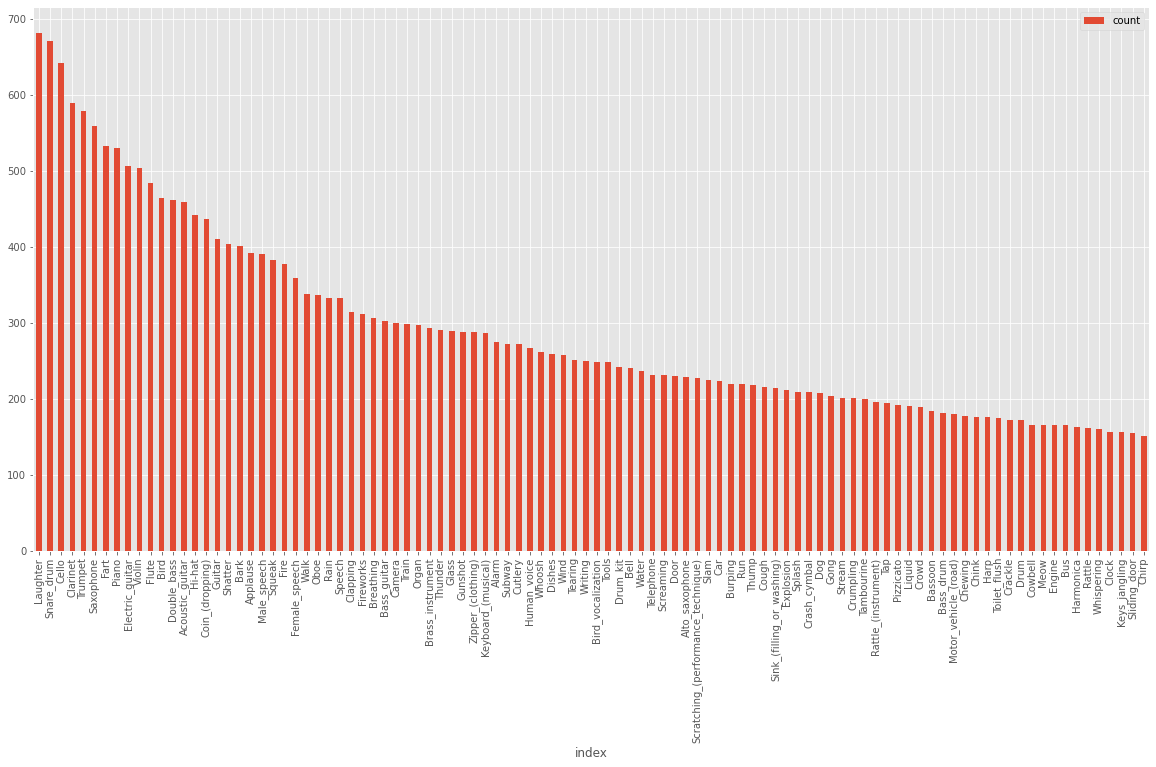

In [10]:
df_sup_count.plot(kind='bar', x='index',y='count', stacked=True, figsize=(20,10))

<AxesSubplot:xlabel='index'>

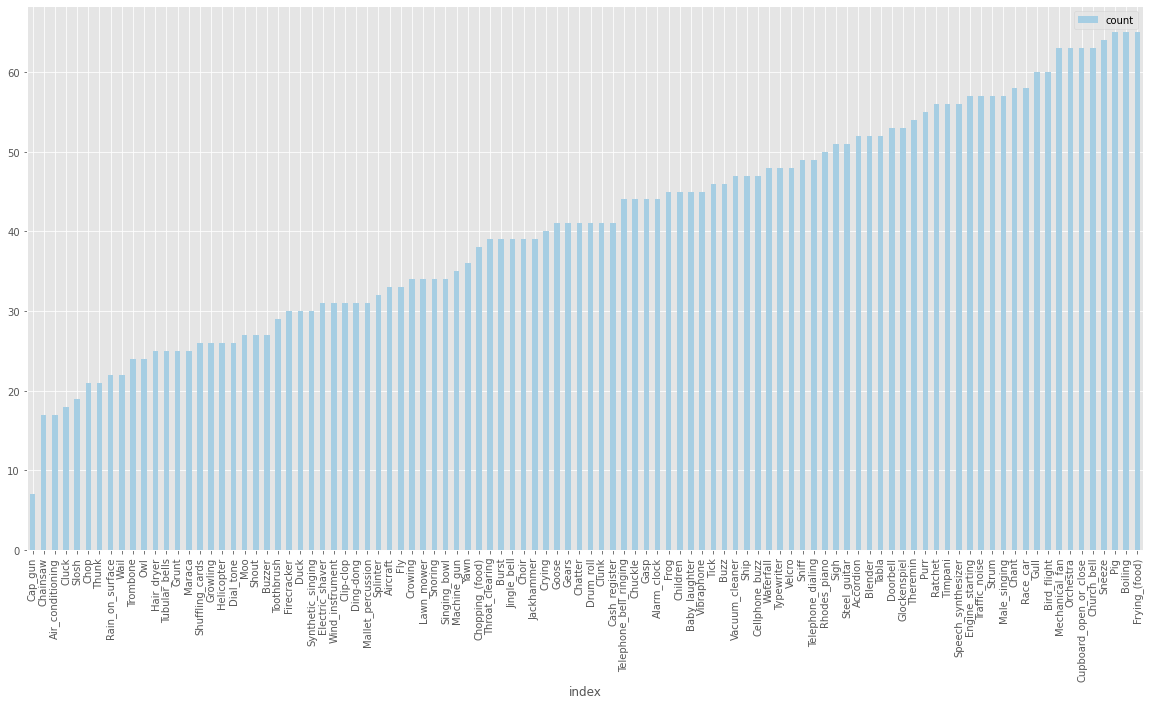

In [11]:
df_inf_count.plot(kind='bar', x='index',y='count',colormap='Paired', figsize=(20,10))

<AxesSubplot:xlabel='index'>

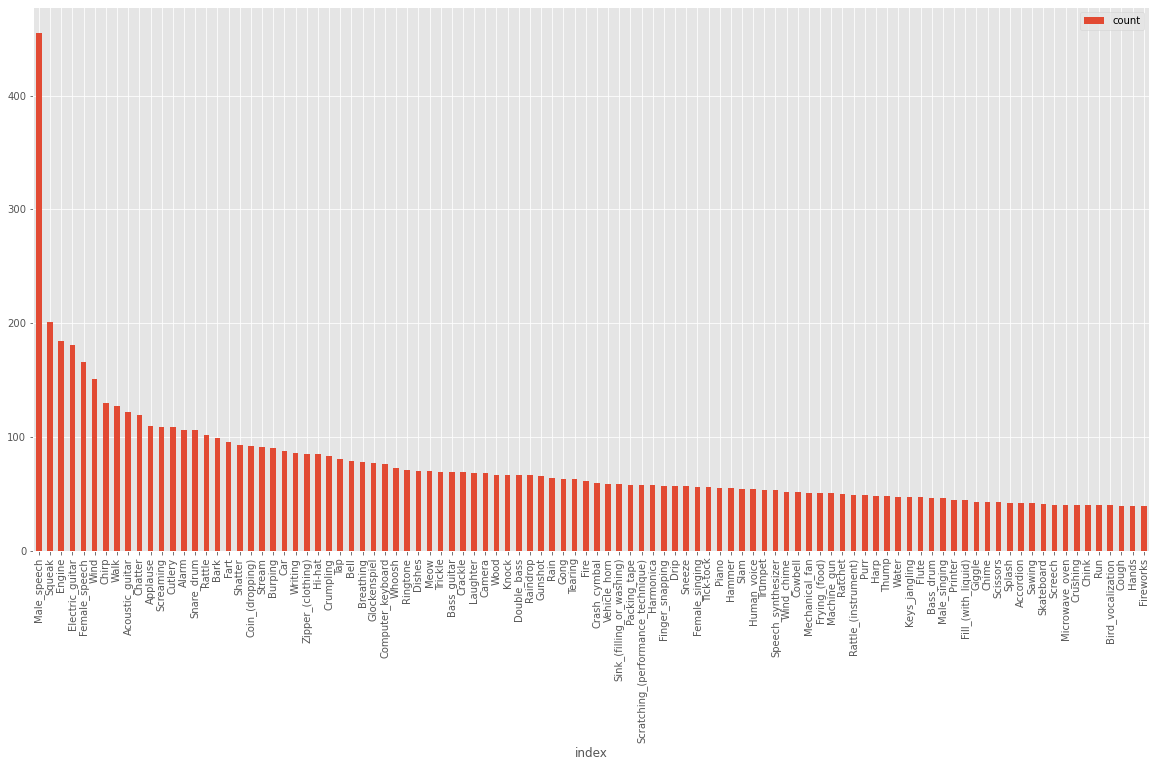

In [12]:
df_sup_count_eval.plot(kind='bar', x='index',y='count', stacked=True, figsize=(20,10))

<AxesSubplot:xlabel='index'>

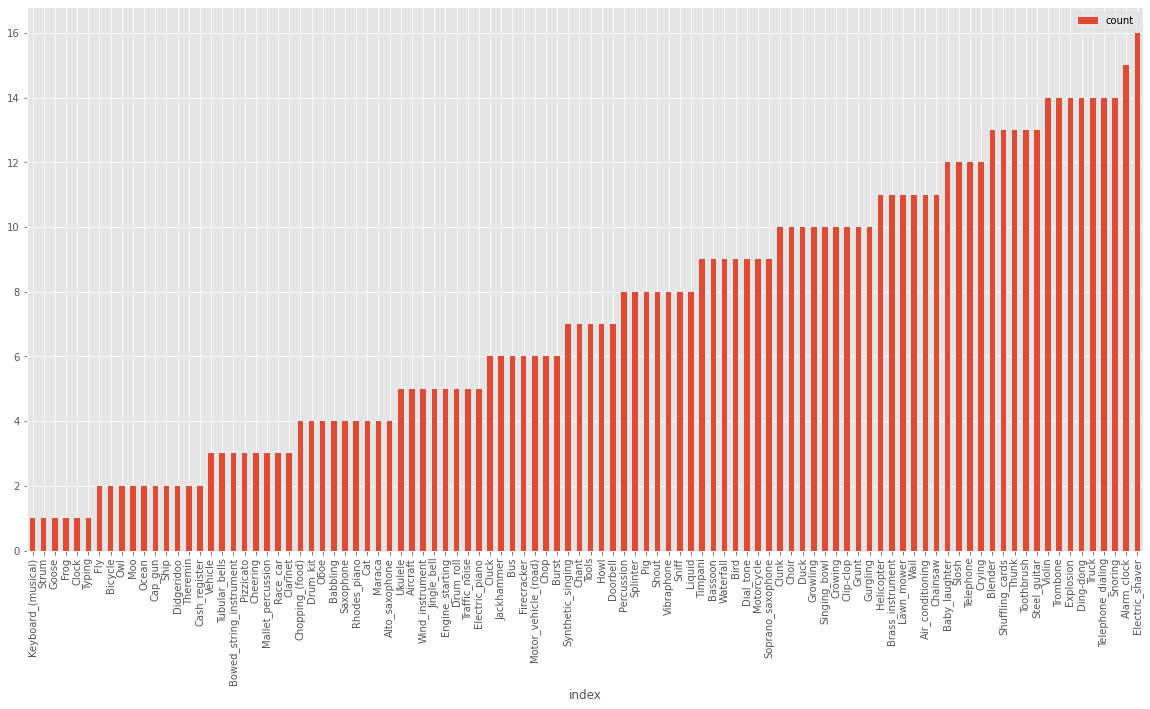

In [13]:
df_inf_count_eval.plot(kind='bar', x='index',y='count', stacked=True, figsize=(20,10))

In [14]:
labels_sample_train =[j for i in dev_csv_dataset['labels'].values.tolist() for j in str(i).split(',')]

In [15]:
labels_sample_eval =[j for i in eval_csv_dataset['labels'].values.tolist() for j in str(i).split(',')]

In [16]:
labels_sample_train = list(set(labels_sample_train))

In [17]:
labels_sample_eval = list(set(labels_sample_eval))

In [18]:
labels_sample_train

['Applause',
 'Bird',
 'Cluck',
 'Sink_(filling_or_washing)',
 'Machine_gun',
 'Rattle',
 'Firecracker',
 'Writing',
 'Drawer_open_or_close',
 'Ship',
 'Glass',
 'Speech',
 'Electric_piano',
 'Bird_vocalization',
 'Cellphone_buzz',
 'Explosion',
 'Shatter',
 'Hair_dryer',
 'Crack',
 'Bicycle_bell',
 'Typing',
 'Frying_(food)',
 'Fireworks',
 'Fly',
 'Air_conditioning',
 'Tambourine',
 'Human_voice',
 'Boom',
 'Stream',
 'Tap',
 'Aircraft',
 'Chop',
 'Male_singing',
 'Goose',
 'Glockenspiel',
 'Harmonica',
 'Scissors',
 'Choir',
 'Owl',
 'Female_singing',
 'Motorcycle',
 'Moo',
 'Hi-hat',
 'Subway',
 'Maraca',
 'Theremin',
 'Water',
 'Zipper_(clothing)',
 'Shuffling_cards',
 'Wood',
 'Pizzicato',
 'Drum_kit',
 'Drill',
 'Mallet_percussion',
 'Waterfall',
 'Baby_laughter',
 'Telephone',
 'Electric_shaver',
 'Sniff',
 'Fart',
 'Grunt',
 'Clunk',
 'Tubular_bells',
 'Crushing',
 'Shout',
 'Cash_register',
 'Yawn',
 'Gasp',
 'Gong',
 'Acoustic_guitar',
 'Chant',
 'Chopping_(food)',
 'Marimba

In [19]:
labels_sample_eval

['Applause',
 'Bird',
 'Cluck',
 'Sink_(filling_or_washing)',
 'Machine_gun',
 'Rattle',
 'Firecracker',
 'Writing',
 'Drawer_open_or_close',
 'Ship',
 'Glass',
 'Speech',
 'Electric_piano',
 'Bird_vocalization',
 'Cellphone_buzz',
 'Explosion',
 'Shatter',
 'Hair_dryer',
 'Crack',
 'Bicycle_bell',
 'Typing',
 'Frying_(food)',
 'Fireworks',
 'Boom',
 'Air_conditioning',
 'Fly',
 'Human_voice',
 'Tambourine',
 'Tap',
 'Stream',
 'Aircraft',
 'Chop',
 'Male_singing',
 'Goose',
 'Glockenspiel',
 'Harmonica',
 'Scissors',
 'Choir',
 'Owl',
 'Female_singing',
 'Motorcycle',
 'Moo',
 'Hi-hat',
 'Subway',
 'Maraca',
 'Theremin',
 'Water',
 'Zipper_(clothing)',
 'Shuffling_cards',
 'Wood',
 'Pizzicato',
 'Drum_kit',
 'Drill',
 'Mallet_percussion',
 'Waterfall',
 'Baby_laughter',
 'Telephone',
 'Electric_shaver',
 'Sniff',
 'Fart',
 'Grunt',
 'Clunk',
 'Tubular_bells',
 'Crushing',
 'Shout',
 'Cash_register',
 'Yawn',
 'Gasp',
 'Gong',
 'Acoustic_guitar',
 'Chant',
 'Chopping_(food)',
 'Marimba

In [20]:
print(len(labels_sample_train))
print(len(labels_sample_eval))

262
262
